In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("train.csv")

# Exploratory Variable Analysis
Jordan & Joe will analyze the first 40 variables, from "MSSubClass", to "HeatingQC"
Things to keep in mind:
* Which variables should we dummify?
* How will we handle missing values?  Do we drop the row, impute using the mean, or use kNN?
* Do any of the features look skewed?  Should we transform them using Box-Cox, log, sqrt?
* Quick correlation plots.  Variables with high corrleation to prices should be prioritized as predictors
* How to deal with outliers?
* How to deal with multi-collinearity?

In [3]:
# We have 80 columns (79 predictors, 1 response variable) and 1,459 observations
df.shape

(1460, 81)

In [4]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# Tuning ratio for total basement SF
ratios = np.linspace(0.1,1,10)
corr = []
for ratio in ratios:
    df['AdjTotalBsmtSF']= df['BsmtFinSF1']+df['BsmtFinSF2']+ratio*df['BsmtUnfSF']
    corr.append(df['AdjTotalBsmtSF'].corr(df['SalePrice']))
corr
# Optimal ratio is 0.9

[0.4054654342861163,
 0.4452598476794081,
 0.48431754798790005,
 0.5209102207163353,
 0.5531819398188516,
 0.5794721290821154,
 0.5986571901276568,
 0.6103722259699292,
 0.615019645406191,
 0.6135805515591954]

In [142]:
df['AdjTotalBsmtSF']= df['BsmtFinSF1']+df['BsmtFinSF2']+0.9*df['BsmtUnfSF']

In [8]:
# Tuning ratio for total bathroom
ratios = np.linspace(0.1,1,10)
corr = []
for ratio in ratios:
    df['AdjTotalBath']= df['FullBath']+df['BsmtFullBath']+ratio*(df['HalfBath']+df['BsmtHalfBath'])
    corr.append(df['AdjTotalBath'].corr(df['SalePrice']))
corr
# Optimal ratio is 0.6

[0.5997153811176471,
 0.6129329206417322,
 0.6225582930170263,
 0.6287320463777247,
 0.6317310679319873,
 0.6319253386721281,
 0.6297333501528938,
 0.6255832702191102,
 0.6198836693831157,
 0.6130046086468921]

In [143]:
df['AdjTotalBath']= df['FullBath']+df['BsmtFullBath']+0.6*(df['HalfBath']+df['BsmtHalfBath'])

In [9]:
# Tuning ratio for HouseAge
ratios = np.linspace(0.1,1,10)
corr = []
for ratio in ratios:
    df['HouseAge']= df['YrSold']-(ratio*df['YearRemodAdd']+(1-ratio)*df['YearBuilt'])
    corr.append(df['HouseAge'].corr(df['SalePrice']))
corr
# Optimal ratio is 0.6,0.4

[-0.5368092592420309,
 -0.5497842183783016,
 -0.5615428438577365,
 -0.5710758554742427,
 -0.577091462745863,
 -0.5780924588805421,
 -0.5725794361501938,
 -0.5593837994802119,
 -0.5380473859888313,
 -0.5090787380156294]

In [144]:
df['HouseAge']= df['YrSold']-(0.6*df['YearRemodAdd']+0.4*df['YearBuilt'])

In [10]:
df['LogSalePrice']=np.log(df['SalePrice'])
df['LogSalePrice'].head()
df['LogSalePrice'].describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: LogSalePrice, dtype: float64

In [154]:
df['AdjOutdoorSF'] = df['3SsnPorch']+df['EnclosedPorch']+df['OpenPorchSF']+df['ScreenPorch']+df['WoodDeckSF']
df['AdjOutdoorSF'].corr(df['LogSalePrice'])

0.3983867067095287

In [11]:
# Example: if we want to find outliers in "LotFrontage", defined by 5 stdev from mean
# This will return all such rows where LotFrontage is 5 stdev from the mean
def index_of_outliers(df, series_name, stdev_threshold):
    mask = np.abs(df[series_name] - df[series_name].mean()) >= (stdev_threshold*df[series_name].std())
    return df.index[mask].tolist()

In [12]:
def EDA_categorical(df, series_name):
    print("Number of missing values: ", df[series_name].isna().sum())
    print("")
    print("Unique values and their frequencies:")
    print(df[series_name].value_counts(sort = True))
    print("")
    print("Mean LogSalePrice in different groups of",series_name)
    cat_group = df.groupby(series_name)['LogSalePrice'].mean().sort_values(ascending=False)
    print(cat_group)
    cat_group.plot.bar(x=series_name,y='LogSalePrice')
    plt.ylim(cat_group.values[-1]-0.3, cat_group.values[0]+0.3) # setting the y limits to 0.3 below min and 0.3 above max
    
    

In [13]:
def EDA_numeric(df, series_name):
    print("Number of missing values: ", df[series_name].isna().sum())
    print("")
    print("Quantile analysis:")
    print(df[series_name].describe())
    print("")
    print("Correlation with housing prices:%.2f" % df[series_name].corr(df["SalePrice"]))
    #print(round(df[series_name].corr(df["SalePrice"]),2))
    #print("May's visual tools for identifying outliers")
    # df[series_name].hist()
    # df.plot.scatter(x=series_name, y ='SalePrice')
    #print('*'*10)
    lis = index_of_outliers(df,series_name,stdev_threshold = 4)
    #print(round(df[series_name].drop(lis).corr(df["SalePrice"]),2))
    print("Correlation with housing price after removing outliers: %.2f" %df[series_name].drop(lis).corr(df["SalePrice"]))
    print("Number of outliers that is removed:" + str(len(lis)))
    print("Plots after removing outliers")
    
    plt.hist(df[series_name].drop(lis), color="green")
    df.drop(lis).plot.scatter(x=series_name, y ='LogSalePrice',color = 'green')
   
#     df.drop(lis).plot.scatter(x=series_name, y ='SalePrice',color = 'green')

In [14]:
from scipy import stats
def box_cox_transform(df, series_name):
    df_series_transformed, _ = stats.boxcox(df[series_name])
    return df_series_transformed

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       35.882481
std        17.390176
min         0.000000
25%        25.063437
50%        36.754104
75%        47.670569
max        79.966859
Name: BsmtUnfSF_Box_Cox, dtype: float64

Correlation with housing prices:0.20
Correlation with housing price after removing outliers: 0.20
Number of outliers that is removed:0
Plots after removing outliers


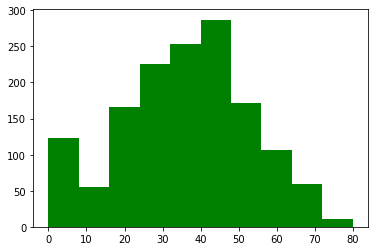

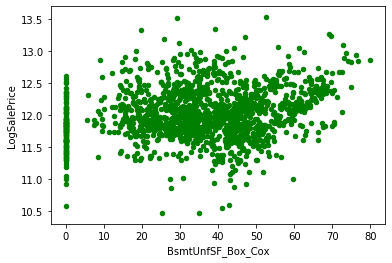

In [15]:
df["BsmtUnfSFPos"] = df["BsmtUnfSF"] + 1.0
df["BsmtUnfSF_Box_Cox"] = box_cox_transform(df, "BsmtUnfSFPos")
EDA_numeric(df, "BsmtUnfSF_Box_Cox")

Number of missing values:  0

Unique values and their frequencies:
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

Mean LogSalePrice in different groups of MSSubClass
MSSubClass
60     12.339975
120    12.171554
75     12.064780
20     12.052788
80     12.021825
70     11.964045
85     11.895866
40     11.870422
50     11.814537
160    11.807190
90     11.780920
190    11.734853
45     11.579033
180    11.501750
30     11.433809
Name: LogSalePrice, dtype: float64


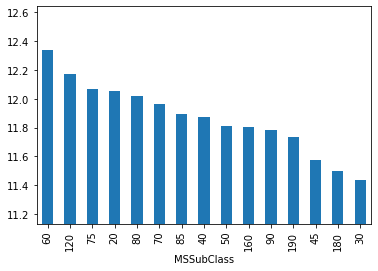

In [16]:
EDA_categorical(df, "MSSubClass")

In [17]:
#  def histogram_after_outliersremoved(df,series_name):
#     lis = index_of_outliers(df,series_name,stdev_threshold = 5
#     df[series_name].drop(lis).hist(color = 'green')
#     df.drop(lis).plot.scatter(x=series_name, y ='SalePrice',color = 'green')

In [18]:
# histogram_after_outliersremoved(df,'HouseAge')

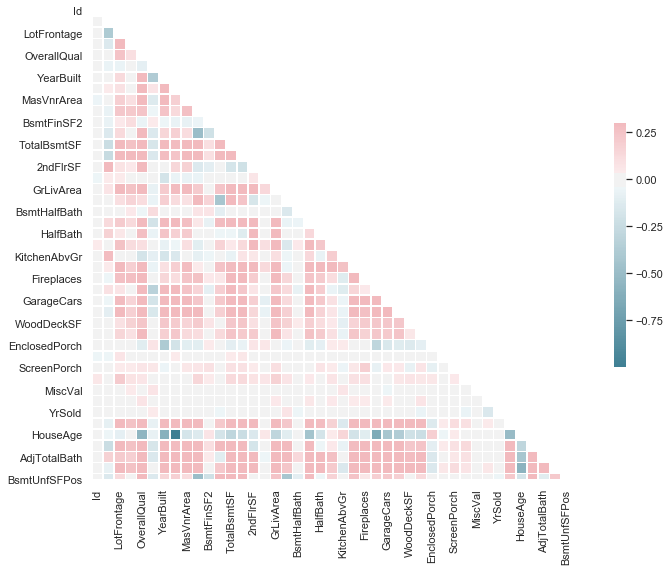

In [19]:
# Check Correlations Between Variables
from string import ascii_letters
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Variable 1: MSSubClass (Identifies the type of dwelling involved in the sale.)

Number of missing values:  0

Unique values and their frequencies:
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

Mean LogSalePrice in different groups of MSSubClass
MSSubClass
60     12.339975
120    12.171554
75     12.064780
20     12.052788
80     12.021825
70     11.964045
85     11.895866
40     11.870422
50     11.814537
160    11.807190
90     11.780920
190    11.734853
45     11.579033
180    11.501750
30     11.433809
Name: LogSalePrice, dtype: float64


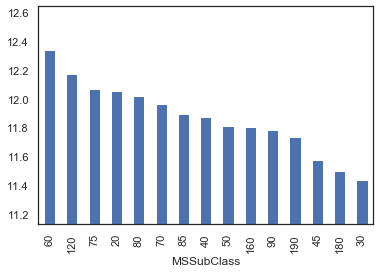

In [20]:
EDA_categorical(df, "MSSubClass")

### Resolve Conflicts between MSSubClass & HouseStyle

In [21]:
# Define two auxiliary functions to help us comb through this data
#   to find conflicts between the labels of the columns "MSSubClass" and "HouseStyle"
def HouseStyle_Value_Count_for_MSSubClass(df, MSSubClass_label, description):
    print("")
    print("#"*75)
    print("For MSSubClass =",MSSubClass_label,"(",description,")","\nThe values & frequencies of HouseStyle are:")
    print(df.loc[df["MSSubClass"]==MSSubClass_label,"HouseStyle"].value_counts())
    print("")

def Find_MSSubClass_HouseStyle_Conflict(df, MSSubClass_label, HouseStyle_label):
    rows_with_conflict = (df["MSSubClass"]==MSSubClass_label) & (df["HouseStyle"]==HouseStyle_label)
    if (sum(rows_with_conflict) >= 1):
        print("Grabbing problematic observations where MSSubClass =",MSSubClass_label,"but","HouseStyle =", HouseStyle_label,"...")
    else:
        raise ValueError("No rows matching this criterion!")
    return rows_with_conflict

# Variable 2: MSZoning (Identifies the general zoning classification of the sale.)

In [22]:
# MSSubClass = 20: 1-STORY 1946 & NEWER ALL STYLES
HouseStyle_Value_Count_for_MSSubClass(df, 20, "1-STORY 1946 & NEWER ALL STYLES")
mask_1 = Find_MSSubClass_HouseStyle_Conflict(df, 20, "2Story")
mask_2 = Find_MSSubClass_HouseStyle_Conflict(df, 20, "SLvl")

# MSSubClass = 30: 1-STORY 1945 & OLDER
HouseStyle_Value_Count_for_MSSubClass(df, 30, "1-STORY 1945 & OLDER")
mask_3 = Find_MSSubClass_HouseStyle_Conflict(df, 30, "1.5Fin")
mask_4 = Find_MSSubClass_HouseStyle_Conflict(df, 30, "1.5Unf")

# MSSubClass = 40: 1-STORY W/FINISHED ATTIC ALL AGES
HouseStyle_Value_Count_for_MSSubClass(df, 40, "1-STORY W/FINISHED ATTIC ALL AGES")

# MSSubClass = 45: 1-1/2 STORY - UNFINISHED ALL AGES
HouseStyle_Value_Count_for_MSSubClass(df, 45, "1-1/2 STORY - UNFINISHED ALL AGES")

# MSSubClass = 50: 1-1/2 STORY FINISHED ALL AGES
HouseStyle_Value_Count_for_MSSubClass(df, 50, "1-1/2 STORY FINISHED ALL AGES")
mask_5 = Find_MSSubClass_HouseStyle_Conflict(df, 50, "2Story")

# MSSubClass = 60: 2-STORY 1946 & NEWER
HouseStyle_Value_Count_for_MSSubClass(df, 60, "2-STORY 1946 & NEWER")
mask_6 = Find_MSSubClass_HouseStyle_Conflict(df, 60, "SLvl")

# MSSubClass = 70: 2-STORY 1945 & OLDER
HouseStyle_Value_Count_for_MSSubClass(df, 70, "2-STORY 1945 & OLDER")
mask_7 = Find_MSSubClass_HouseStyle_Conflict(df, 70, "2.5Fin")

# MSSubClass = 75: 2-1/2 STORY ALL AGES
HouseStyle_Value_Count_for_MSSubClass(df, 75, "2-1/2 STORY ALL AGES")
mask_8 = Find_MSSubClass_HouseStyle_Conflict(df, 75, "2Story")

# MSSubClass = 80: SPLIT OR MULTI-LEVEL
HouseStyle_Value_Count_for_MSSubClass(df, 80, "SPLIT OR MULTI-LEVEL")

# MSSubClass = 85: SPLIT FOYER
HouseStyle_Value_Count_for_MSSubClass(df, 85, "SPLIT FOYER")

# MSSubClass = 90: DUPLEX - ALL STYLES AND AGES
HouseStyle_Value_Count_for_MSSubClass(df, 90, "DUPLEX - ALL STYLES AND AGES")
print("??? I need to do more research on Duplexes...how many floors should they have???")

# MSSubClass = 120: 1-STORY PUD (Planned Unit Development) - 1946 & NEWER
HouseStyle_Value_Count_for_MSSubClass(df, 120, "1-STORY PUD (Planned Unit Development) - 1946 & NEWER")
mask_9 = Find_MSSubClass_HouseStyle_Conflict(df, 120, "SFoyer")

# MSSubClass = 150: 1-1/2 STORY PUD - ALL AGES
HouseStyle_Value_Count_for_MSSubClass(df, 150, "1-1/2 STORY PUD - ALL AGES")
print("How many rows have MSSubClass = 150?",sum(df["MSSubClass"] == 150))

# MSSubClass = 160: 2-STORY PUD - 1946 & NEWER
HouseStyle_Value_Count_for_MSSubClass(df, 160, "2-STORY PUD - 1946 & NEWER")

# MSSubClass = 180: PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
HouseStyle_Value_Count_for_MSSubClass(df, 180, "PUD - MULTILEVEL - INCL SPLIT LEV/FOYER")

# MSSubClass = 190: 2 FAMILY CONVERSION - ALL STYLES AND AGES
HouseStyle_Value_Count_for_MSSubClass(df, 190, "2 FAMILY CONVERSION - ALL STYLES AND AGES")
print("??? I need to do more research on 2-family conversion...what does this mean???")

# We can dummify these types of dwellings, or we can just make dummy variables indicating
#   "Yes, 1946 and newer" vs. "No, 1945 and older" because this information is really important
#   But we don't have it for every single type of MSSubClass
print("Potential solution:")
print("(1) Throw out observations with type conflicts found in these boolean masks")
print("(2) Then dummify the MSSubClass")
print("??? How do we dummify MSSubClass???")


###########################################################################
For MSSubClass = 20 ( 1-STORY 1946 & NEWER ALL STYLES ) 
The values & frequencies of HouseStyle are:
1Story    534
2Story      1
SLvl        1
Name: HouseStyle, dtype: int64

Grabbing problematic observations where MSSubClass = 20 but HouseStyle = 2Story ...
Grabbing problematic observations where MSSubClass = 20 but HouseStyle = SLvl ...

###########################################################################
For MSSubClass = 30 ( 1-STORY 1945 & OLDER ) 
The values & frequencies of HouseStyle are:
1Story    67
1.5Fin     1
1.5Unf     1
Name: HouseStyle, dtype: int64

Grabbing problematic observations where MSSubClass = 30 but HouseStyle = 1.5Fin ...
Grabbing problematic observations where MSSubClass = 30 but HouseStyle = 1.5Unf ...

###########################################################################
For MSSubClass = 40 ( 1-STORY W/FINISHED ATTIC ALL AGES ) 
The values & frequencies of HouseStyle a

# Variable 2: Categorical MsZoning

Number of missing values:  0

Unique values and their frequencies:
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Mean LogSalePrice in different groups of MSZoning
MSZoning
FV         12.246616
RL         12.085885
RH         11.749840
RM         11.692893
C (all)    11.118259
Name: LogSalePrice, dtype: float64


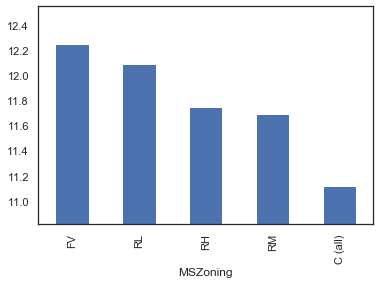

In [23]:
EDA_categorical(df, "MSZoning")

# Variable 3: LotFrontage (Linear feet of street connected to property)

Number of missing values:  259

Quantile analysis:
count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

Correlation with housing prices:0.35
Correlation with housing price after removing outliers: 0.38
Number of outliers that is removed:6
Plots after removing outliers


C:\Users\zhang\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\zhang\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


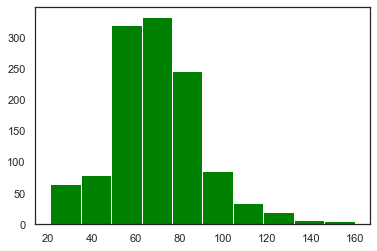

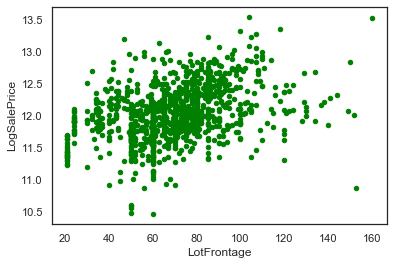

In [24]:
EDA_numeric(df, "LotFrontage")

In [25]:
print("There is so much data missing: 259 observations missing out of 1,460...")
print("??? What should we do with this???")

There is so much data missing: 259 observations missing out of 1,460...
??? What should we do with this???


# Variable 4: LotArea (Lot size in square feet)

Number of missing values:  0

Quantile analysis:
count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

Correlation with housing prices:0.26
Correlation with housing price after removing outliers: 0.38
Number of outliers that is removed:10
Plots after removing outliers


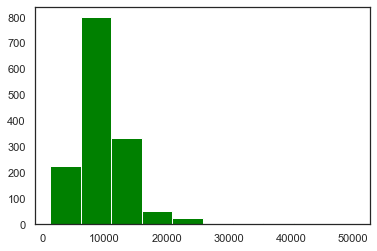

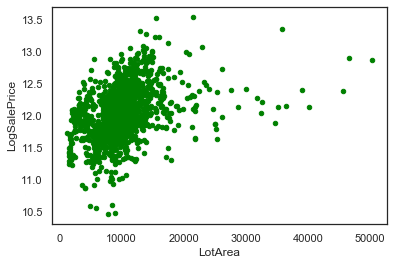

In [26]:
EDA_numeric(df, "LotArea")

In [27]:
# The square root of "LotArea" should be highly correlated to "LotFrontage"
print("Correlation of lot area square rooted vs. length of property touching street:")
print(round(df["LotFrontage"].corr(df["LotArea"]**0.5),2))
print("")

# Maybe we can just drop LotFrontage, then?
print("??? One thing that we can try is using feature selection like Lasso to decide if we should include LotFrontage, when we already have LotArea???")

Correlation of lot area square rooted vs. length of property touching street:
0.6

??? One thing that we can try is using feature selection like Lasso to decide if we should include LotFrontage, when we already have LotArea???


# Variable 5: Street (Type of road access to property)

Number of missing values:  0

Unique values and their frequencies:
Pave    1454
Grvl       6
Name: Street, dtype: int64

Mean LogSalePrice in different groups of Street
Street
Pave    12.025522
Grvl    11.667435
Name: LogSalePrice, dtype: float64


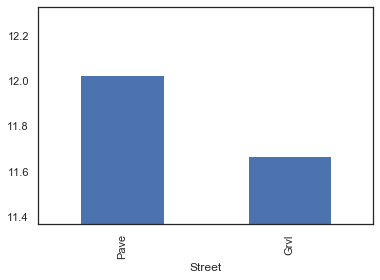

In [28]:
EDA_categorical(df, "Street")

In [29]:
print("There are a lot of variables in here with semi-decent predictive power, but if we include all of them, it will cause a lot of issues with multi-collinearity")
print("")
print("One option is: we can rank the variables based on their correlation to housing prices, and drop the ones with the lowest to start with")
print("???")

There are a lot of variables in here with semi-decent predictive power, but if we include all of them, it will cause a lot of issues with multi-collinearity

One option is: we can rank the variables based on their correlation to housing prices, and drop the ones with the lowest to start with
???


# Variable 6: Alley (Type of alley access to property)

Number of missing values:  1369

Unique values and their frequencies:
Grvl    50
Pave    41
Name: Alley, dtype: int64

Mean LogSalePrice in different groups of Alley
Alley
Pave    11.996812
Grvl    11.673354
Name: LogSalePrice, dtype: float64


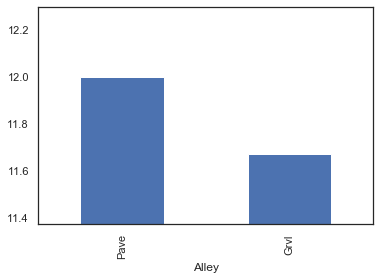

In [30]:
EDA_categorical(df, "Alley")

In [31]:
print("1369 out of 1,460 missing...I vote to drop this variable completely")

1369 out of 1,460 missing...I vote to drop this variable completely


# Variable 7: LotShape (General shape of property)

Number of missing values:  0

Unique values and their frequencies:
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

Mean LogSalePrice in different groups of LotShape
LotShape
IR2    12.318450
IR3    12.205413
IR1    12.163465
Reg    11.936094
Name: LogSalePrice, dtype: float64


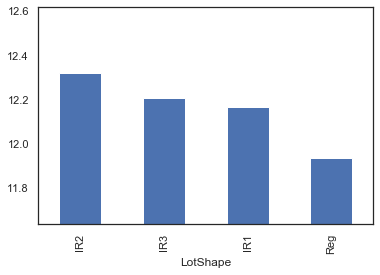

In [32]:
EDA_categorical(df, "LotShape")

In [33]:
print("I don't see a strong reason to include this one...what do you think?")

I don't see a strong reason to include this one...what do you think?


# Variable 8: LandContour (Flatness of the property)

Number of missing values:  0

Unique values and their frequencies:
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Mean LogSalePrice in different groups of LandContour
LandContour
HLS    12.259257
Low    12.120086
Lvl    12.022694
Bnk    11.810740
Name: LogSalePrice, dtype: float64


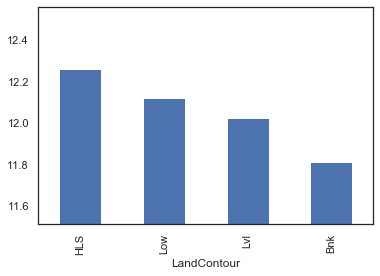

In [34]:
EDA_categorical(df, "LandContour")

In [35]:
print("For variables like this, where we are not missing any values, we can easily dummify them and include them in our model, but the number of variables quickly explodes.  Let's say that we have 50 variables that are categorical, each with 5 different unique numbers, then dummification will produce 250 total features, compared to 1,460 observations, which makes it very hard to invert matrices when finding the normal equation")

For variables like this, where we are not missing any values, we can easily dummify them and include them in our model, but the number of variables quickly explodes.  Let's say that we have 50 variables that are categorical, each with 5 different unique numbers, then dummification will produce 250 total features, compared to 1,460 observations, which makes it very hard to invert matrices when finding the normal equation


# Variable 9: Utilities (Type of utilities available)

Number of missing values:  0

Unique values and their frequencies:
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Mean LogSalePrice in different groups of Utilities
Utilities
AllPub    12.024183
NoSeWa    11.831379
Name: LogSalePrice, dtype: float64


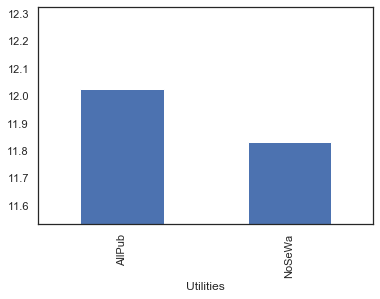

In [36]:
EDA_categorical(df, "Utilities")

In [37]:
print("Drop variable for sure")

Drop variable for sure


# Variable 10: LotConfig (Lot configuration)

Number of missing values:  0

Unique values and their frequencies:
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Mean LogSalePrice in different groups of LotConfig
LotConfig
CulDSac    12.249810
FR3        12.195684
FR2        12.034741
Corner     12.027446
Inside     12.001900
Name: LogSalePrice, dtype: float64


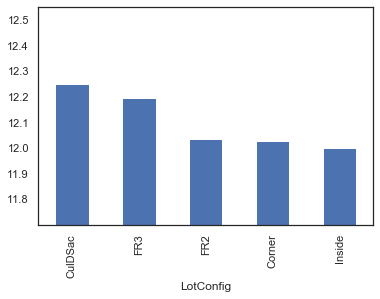

In [38]:
EDA_categorical(df, "LotConfig")

In [39]:
# I think this is an important feature because usually Cul-de-sac houses are more expensive

# Variable 11: LandSlope

In [40]:
# Isn't LandContour same thing as LandSlope?  Their correlation is probably very high
# Here is a post on correlations between categorical variables:
#   https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# Shall we test here and see if these two are redundant???

Number of missing values:  0

Unique values and their frequencies:
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Mean LogSalePrice in different groups of LandSlope
LandSlope
Sev    12.130561
Mod    12.076866
Gtl    12.020565
Name: LogSalePrice, dtype: float64


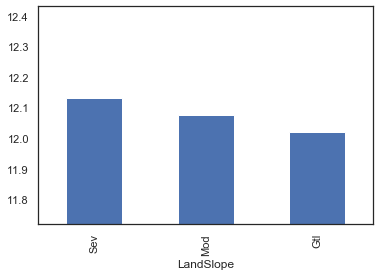

In [41]:
EDA_categorical(df, "LandSlope")

# Variable 12: Neighborhood (Physical locations within Ames city limits)

Number of missing values:  0

Unique values and their frequencies:
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

Mean LogSalePrice in different groups of Neighborhood
Neighborhood
NoRidge    12.676000
NridgHt    12.619411
StoneBr    12.585486
Timber     12.363455
Veenker    12.344176
Somerst    12.296495
ClearCr    12.239900
Crawfor    12.206659
Blmngtn    12.169416
CollgCr    12.163641
Gilbert    12.155803
NWAmes     12.130609
SawyerW    12.090689
Mitchel    11.933948
NAmes      11.868045
NPkVill    11.866477
SWISU      11.838435
Blueste    11.826536
Sawyer     11.811468
Edwards    11.712312
OldTown    11.703865
BrkSide    11.67

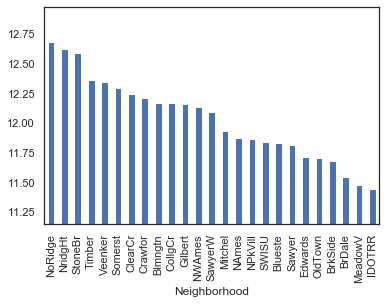

In [42]:
EDA_categorical(df, "Neighborhood")

In [43]:
# I have no doubt that this variable is very important for predicting housing prices

# Variable 13: Condition1 (Proximity to various conditions)

Number of missing values:  0

Unique values and their frequencies:
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

Mean LogSalePrice in different groups of Condition1
Condition1
PosA      12.306690
PosN      12.237989
RRNn      12.179093
RRNe      12.158526
RRAn      12.073762
Norm      12.042916
RRAe      11.822302
Feedr     11.818334
Artery    11.741750
Name: LogSalePrice, dtype: float64


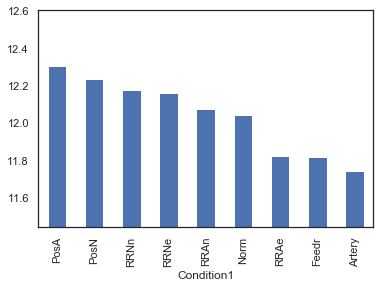

In [44]:
EDA_categorical(df, "Condition1")

In [45]:
# It seems to me like the most common non-normal ones, like "near Feedr" depress housing prices

# Variable 14: Condition2 (Proximity to various conditions if more than one is present)

Number of missing values:  0

Unique values and their frequencies:
Norm      1445
Feedr        6
RRNn         2
PosN         2
Artery       2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

Mean LogSalePrice in different groups of Condition2
Condition2
PosA      12.691580
PosN      12.493879
RRAe      12.154779
Norm      12.025895
RRAn      11.827043
Feedr     11.670631
Artery    11.570036
RRNn      11.435329
Name: LogSalePrice, dtype: float64


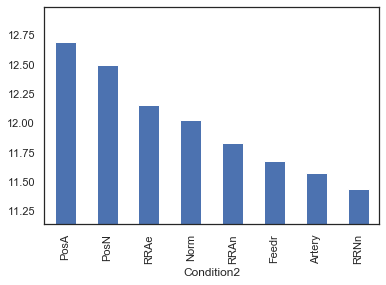

In [46]:
EDA_categorical(df, "Condition2")

In [47]:
# I don't really get this variable and it doesn't have a lot of observations in most subclasses

# Variable 15: BldgType (Type of dwelling)

Number of missing values:  0

Unique values and their frequencies:
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

Mean LogSalePrice in different groups of BldgType
BldgType
TwnhsE    12.059451
1Fam      12.047512
Duplex    11.780920
Twnhs     11.773906
2fmCon    11.725353
Name: LogSalePrice, dtype: float64


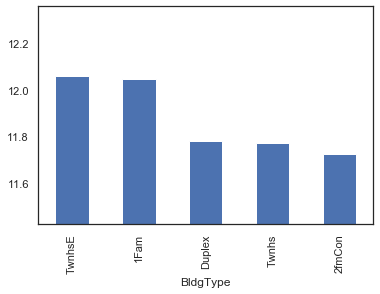

In [48]:
EDA_categorical(df, "BldgType")

In [49]:
# Looks like a useful variable

# Variable 16: HouseStyle

Number of missing values:  0

Unique values and their frequencies:
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

Mean LogSalePrice in different groups of HouseStyle
HouseStyle
2.5Fin    12.194451
2Story    12.182686
SLvl      12.002153
1Story    11.993683
2.5Unf    11.908751
1.5Fin    11.813528
SFoyer    11.786479
1.5Unf    11.595027
Name: LogSalePrice, dtype: float64


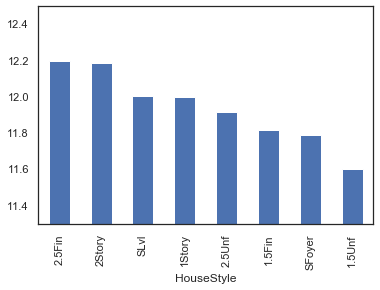

In [50]:
EDA_categorical(df, "HouseStyle")

In [51]:
# This variable looks super important

# Variable 17: OverallQual (Rates the overall material and finish of the house)

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        6.099315
std         1.382997
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

Correlation with housing prices:0.79
Correlation with housing price after removing outliers: 0.79
Number of outliers that is removed:0
Plots after removing outliers


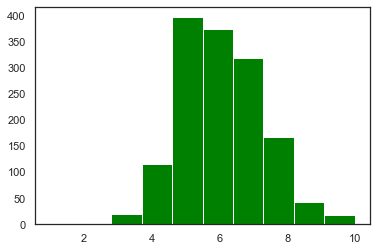

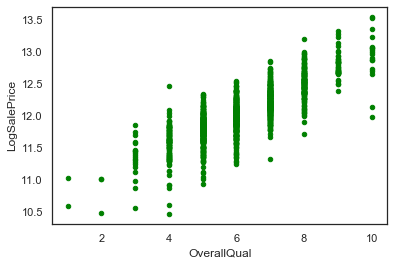

In [52]:
EDA_numeric(df, "OverallQual")

In [53]:
# Very strong correlation.  Absolutely keep this variable

# Variable 18: OverallCond (Rates the overall condition of the house)

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        5.575342
std         1.112799
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64

Correlation with housing prices:-0.08
Correlation with housing price after removing outliers: -0.08
Number of outliers that is removed:1
Plots after removing outliers


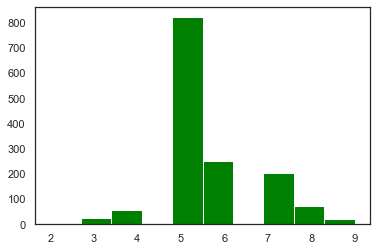

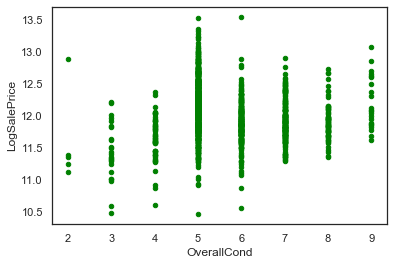

In [54]:
EDA_numeric(df, "OverallCond")

Number of missing values:  0

Unique values and their frequencies:
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

Mean LogSalePrice in different groups of OverallCond
OverallCond
9    12.198866
5    12.144178
7    11.921358
8    11.909391
6    11.890024
4    11.645287
2    11.593353
3    11.438466
1    11.018629
Name: LogSalePrice, dtype: float64


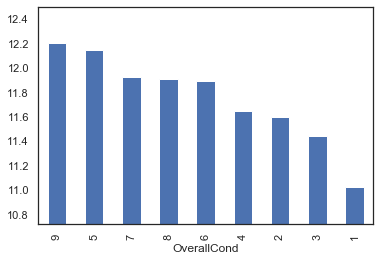

In [55]:
EDA_categorical(df, "OverallCond")

In [56]:
# This is very strange...why is this happening?  How can this be so weak?  Do we have outliers???

# Variable 19: YearBuilt (Original construction date)

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

Correlation with housing prices:0.52
Correlation with housing price after removing outliers: 0.52
Number of outliers that is removed:0
Plots after removing outliers


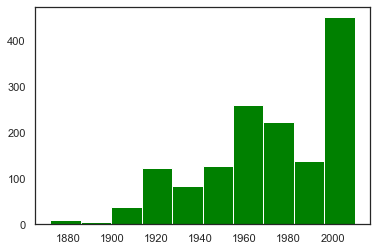

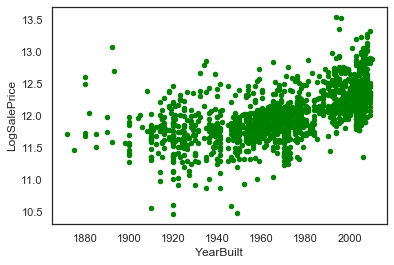

In [57]:
EDA_numeric(df, "YearBuilt")

In [58]:
# Very strong variable, keep it
# Also, we can drop MSSubClass, because MSSubClass has same info as HouseStyle + YearBuilt

# Variable 20: YearRemodAdd

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

Correlation with housing prices:0.51
Correlation with housing price after removing outliers: 0.51
Number of outliers that is removed:0
Plots after removing outliers


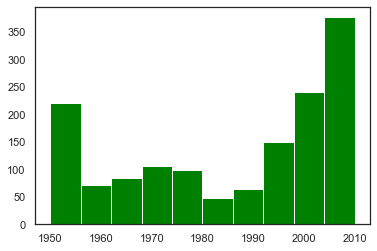

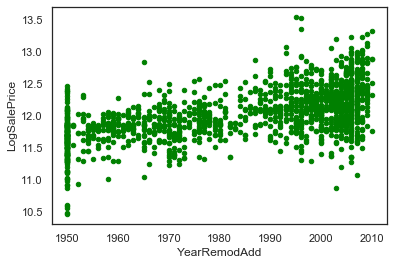

In [59]:
EDA_numeric(df, "YearRemodAdd")

In [60]:
df["YearRemodAdd"].corr(df["YearBuilt"])

0.5928549763436504

In [61]:
# Should we include both YearRemodAdd and YearBuilt???

# Variable 21: RoofStyle

Number of missing values:  0

Unique values and their frequencies:
Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

Mean LogSalePrice in different groups of RoofStyle
RoofStyle
Shed       12.311608
Hip        12.184430
Flat       12.122911
Mansard    12.057425
Gable      11.984200
Gambrel    11.797496
Name: LogSalePrice, dtype: float64


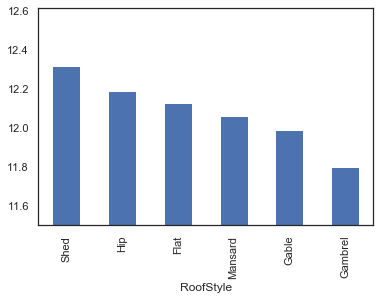

In [62]:
EDA_categorical(df, "RoofStyle")

In [63]:
# I need more context on this one

# Variable 22: RoofMatl

Number of missing values:  0

Unique values and their frequencies:
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
ClyTile       1
Roll          1
Metal         1
Name: RoofMatl, dtype: int64

Mean LogSalePrice in different groups of RoofMatl
RoofMatl
WdShngl    12.763192
Membran    12.394625
WdShake    12.384850
Metal      12.100712
Tar&Grv    12.068078
CompShg    12.019216
ClyTile    11.982929
Roll       11.827736
Name: LogSalePrice, dtype: float64


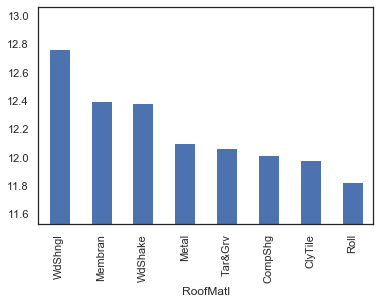

In [64]:
EDA_categorical(df, "RoofMatl")

In [65]:
# Looks like a strong predictor

# Variable 23: Exterior1st

Number of missing values:  0

Unique values and their frequencies:
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
AsphShn      1
CBlock       1
ImStucc      1
Name: Exterior1st, dtype: int64

Mean LogSalePrice in different groups of Exterior1st
Exterior1st
ImStucc    12.476100
Stone      12.456536
VinylSd    12.205873
CemntBd    12.204922
BrkFace    12.088140
Plywood    12.041218
HdBoard    11.951899
Stucco     11.891991
MetalSd    11.859767
WdShing    11.844542
Wd Sdng    11.838506
CBlock     11.561716
AsbShng    11.524514
AsphShn    11.512925
BrkComm    11.158287
Name: LogSalePrice, dtype: float64


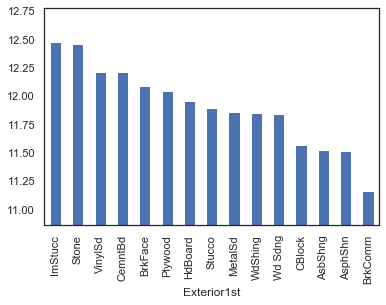

In [66]:
EDA_categorical(df, "Exterior1st")

# Variable 24: Exterior2nd

Number of missing values:  0

Unique values and their frequencies:
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
CBlock       1
Other        1
Name: Exterior2nd, dtype: int64

Mean LogSalePrice in different groups of Exterior2nd
Exterior2nd
Other      12.672946
ImStucc    12.240055
VinylSd    12.209631
CmentBd    12.201948
BrkFace    12.066067
Plywood    11.994743
HdBoard    11.974933
Stone      11.898442
Wd Shng    11.892242
MetalSd    11.862286
Stucco     11.853035
Wd Sdng    11.838480
AsphShn    11.809232
Brk Cmn    11.696284
AsbShng    11.570220
CBlock     11.561716
Name: LogSalePrice, dtype: float64


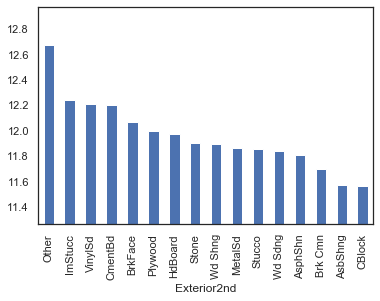

In [67]:
EDA_categorical(df, "Exterior2nd")

In [68]:
# How do we deal with the high correlation between these two variables?
df[["Exterior1st", "Exterior2nd"]].head(n=10)

,Exterior1st,Exterior2nd
0,VinylSd,VinylSd
1,MetalSd,MetalSd
2,VinylSd,VinylSd
3,Wd Sdng,Wd Shng
4,VinylSd,VinylSd
5,VinylSd,VinylSd
6,VinylSd,VinylSd
7,HdBoard,HdBoard
8,BrkFace,Wd Shng
9,MetalSd,MetalSd


# Variable 25: MasVnrType (Masonry veneer type)

Number of missing values:  8

Unique values and their frequencies:
None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Mean LogSalePrice in different groups of MasVnrType
MasVnrType
Stone      12.425138
BrkFace    12.163630
None       11.892919
BrkCmn     11.853239
Name: LogSalePrice, dtype: float64


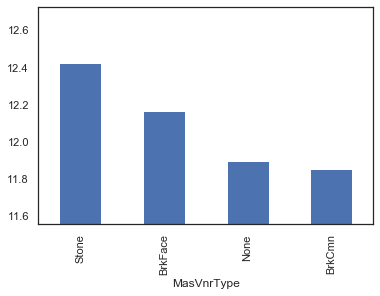

In [69]:
EDA_categorical(df, "MasVnrType")

# Variable 26: MasVnrArea (Masonry veneer area in square feet)

Number of missing values:  8

Quantile analysis:
count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

Correlation with housing prices:0.48
Correlation with housing price after removing outliers: 0.45
Number of outliers that is removed:13
Plots after removing outliers


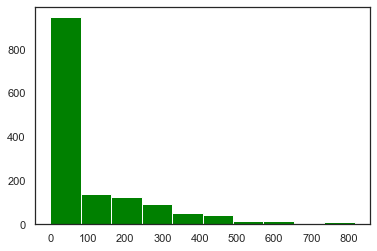

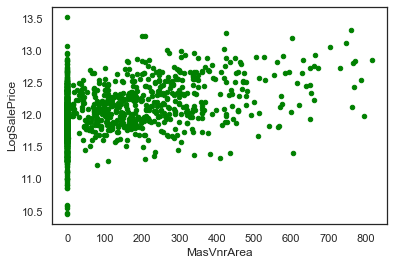

In [70]:
EDA_numeric(df, "MasVnrArea")

In [71]:
df["MasVnrArea"].corr(df["LotArea"])

0.10415982154021268

In [72]:
# We might want to keep this variable as well

# Variable 27: ExterQual

Number of missing values:  0

Unique values and their frequencies:
TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

Mean LogSalePrice in different groups of ExterQual
ExterQual
Ex    12.764044
Gd    12.311282
TA    11.837985
Fa    11.304541
Name: LogSalePrice, dtype: float64


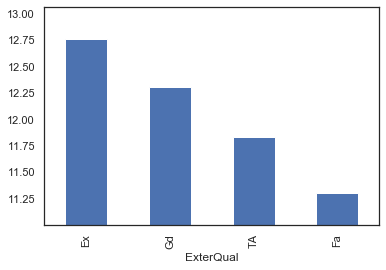

In [73]:
EDA_categorical(df, "ExterQual")

In [74]:
# Very strong predictor

# Variable 28: ExterCond

Number of missing values:  0

Unique values and their frequencies:
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

Mean LogSalePrice in different groups of ExterCond
ExterCond
Ex    12.119727
TA    12.043078
Gd    11.969450
Fa    11.455162
Po    11.245046
Name: LogSalePrice, dtype: float64


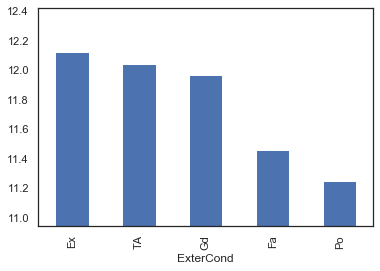

In [75]:
EDA_categorical(df, "ExterCond")

In [76]:
# Strong predictor

# Variable 29: Foundation

Number of missing values:  0

Unique values and their frequencies:
PConc     647
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

Mean LogSalePrice in different groups of Foundation
Foundation
PConc     12.261665
Wood      12.102479
Stone     11.933156
CBlock    11.870080
BrkTil    11.722528
Slab      11.532959
Name: LogSalePrice, dtype: float64


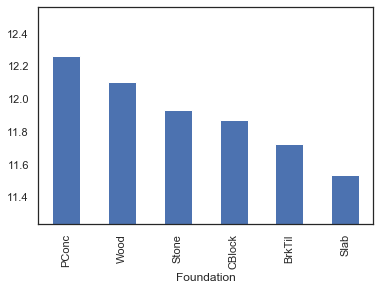

In [77]:
EDA_categorical(df, "Foundation")

In [78]:
# Strong predictor

# Variable 30: BsmtQual (height of basement)

In [159]:
df['BsmtQual1']=df['BsmtQual']
df.loc[df['BsmtQual1'].isnull(), 'BsmtQual1'] = "NO"

Number of missing values:  0

Unique values and their frequencies:
TA    649
Gd    618
Ex    121
NO     37
Fa     35
Name: BsmtQual1, dtype: int64

Mean LogSalePrice in different groups of BsmtQual1
BsmtQual1
Ex    12.640394
Gd    12.179882
TA    11.810855
Fa    11.617600
NO    11.529680
Name: LogSalePrice, dtype: float64


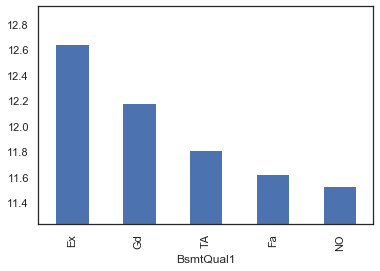

In [160]:
EDA_categorical(df, "BsmtQual")

Number of missing values:  37

Unique values and their frequencies:
TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

Mean LogSalePrice in different groups of BsmtQual
BsmtQual
Ex    12.640394
Gd    12.179882
TA    11.810855
Fa    11.617600
Name: LogSalePrice, dtype: float64


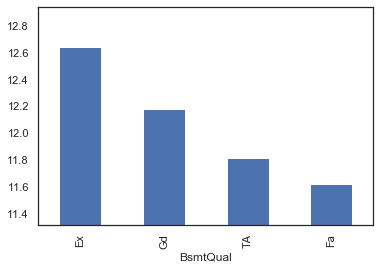

In [79]:
EDA_categorical(df, "BsmtQual")

In [151]:
df['GarageFinish'].corr(df['GarageQual'])

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [80]:
# Strong predictor, and we can convert this into a continuous variable because it is an ordinal categorical variable

# Variable 31: BsmtCond (Evaluates the general condition of the basement)

Number of missing values:  37

Unique values and their frequencies:
TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

Mean LogSalePrice in different groups of BsmtCond
BsmtCond
Gd    12.220279
TA    12.042615
Fa    11.648864
Po    11.065539
Name: LogSalePrice, dtype: float64


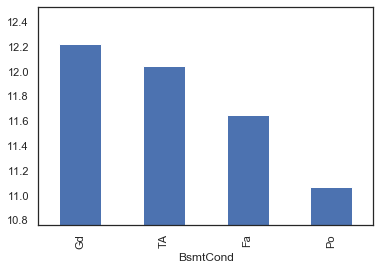

In [81]:
EDA_categorical(df, "BsmtCond")

In [82]:
# Variable should probably be dropped because most are TA, and there are 37 missing variables

# Variable 32: BsmtExposure (Refers to walkout or garden level walls)

Number of missing values:  38

Unique values and their frequencies:
No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

Mean LogSalePrice in different groups of BsmtExposure
BsmtExposure
Gd    12.364359
Av    12.158267
Mn    12.094819
No    11.955653
Name: LogSalePrice, dtype: float64


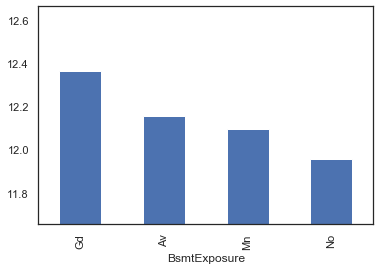

In [83]:
EDA_categorical(df, "BsmtExposure")

In [84]:
# Strong variable for predictions, but there are 38 missing values.  Should we try to just impute using median of "No"?

# Variable 33: BsmtFinType1 (Rating of basement finished area)

Number of missing values:  37

Unique values and their frequencies:
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

Mean LogSalePrice in different groups of BsmtFinType1
BsmtFinType1
GLQ    12.301937
Unf    11.963998
ALQ    11.953313
LwQ    11.881354
BLQ    11.867634
Rec    11.852846
Name: LogSalePrice, dtype: float64


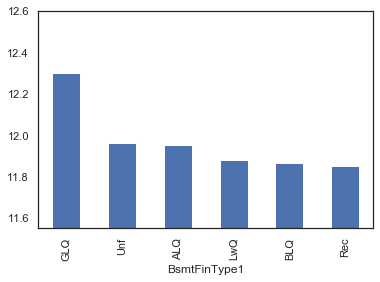

In [85]:
EDA_categorical(df, "BsmtFinType1")

In [86]:
# Strong predictor.  We can convert this into a continuous variable perhaps

# Variable 34: BsmtFinSF1 (Type 1 finished square feet)

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

Correlation with housing prices:0.39
Correlation with housing price after removing outliers: 0.41
Number of outliers that is removed:1
Plots after removing outliers


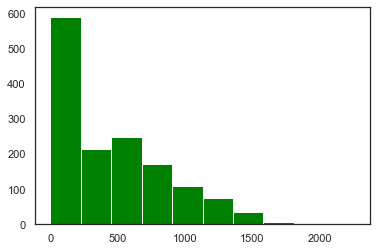

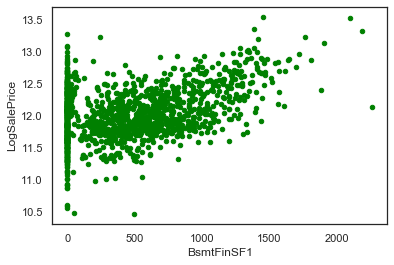

In [87]:
EDA_numeric(df, "BsmtFinSF1")

In [88]:
# We can include this one, I think

# Variable 35: BsmtFinType2 (Rating of basement finished area)

Number of missing values:  38

Unique values and their frequencies:
Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

Mean LogSalePrice in different groups of BsmtFinType2
BsmtFinType2
ALQ    12.167064
Unf    12.043738
GLQ    12.033566
LwQ    11.977832
Rec    11.964644
BLQ    11.888155
Name: LogSalePrice, dtype: float64


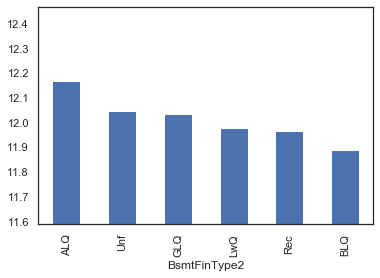

In [89]:
EDA_categorical(df, "BsmtFinType2")

In [90]:
# Should we drop this?

# Variable 36: BsmtFinSF2 (Type 2 finished square feet)

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

Correlation with housing prices:-0.01
Correlation with housing price after removing outliers: -0.07
Number of outliers that is removed:25
Plots after removing outliers


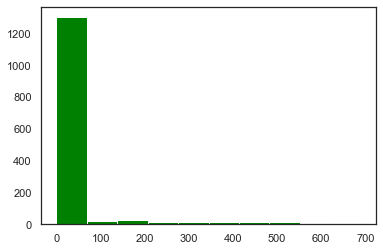

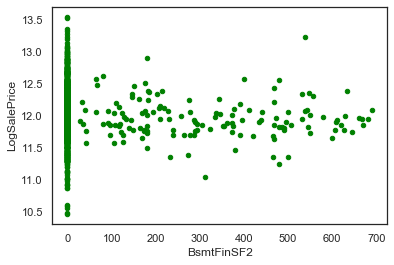

In [91]:
EDA_numeric(df, "BsmtFinSF2")

In [92]:
# This should be thrown out because it looks like most observations here are 0

# Variable 37: BsmtUnfSF (Unfinished square feet of basement area)

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

Correlation with housing prices:0.21
Correlation with housing price after removing outliers: 0.21
Number of outliers that is removed:1
Plots after removing outliers


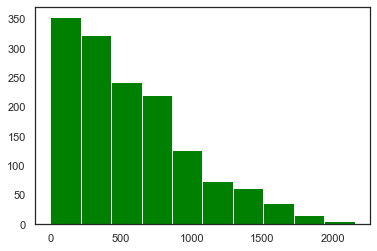

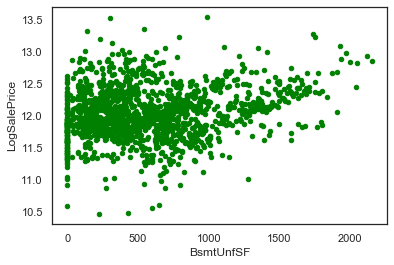

In [93]:
EDA_numeric(df, "BsmtUnfSF")

In [94]:
# Potentially useful variable, though not very convincing

# Variable 38: TotalBsmtSF (Total square feet of basement area)

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

Correlation with housing prices:0.61
Correlation with housing price after removing outliers: 0.64
Number of outliers that is removed:5
Plots after removing outliers


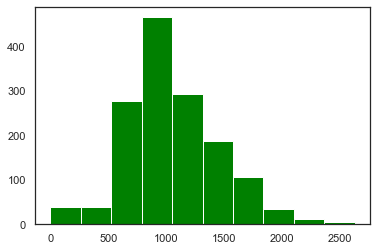

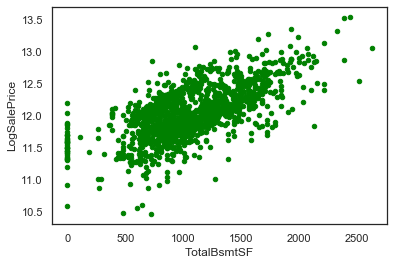

In [95]:
EDA_numeric(df, "TotalBsmtSF")

In [96]:
# Very strong predictor

# Variable 39: Heating (Type of heating)

Number of missing values:  0

Unique values and their frequencies:
GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

Mean LogSalePrice in different groups of Heating
Heating
GasA     12.032078
GasW     11.930687
OthW     11.741606
Wall     11.429740
Floor    11.191342
Grav     11.165886
Name: LogSalePrice, dtype: float64


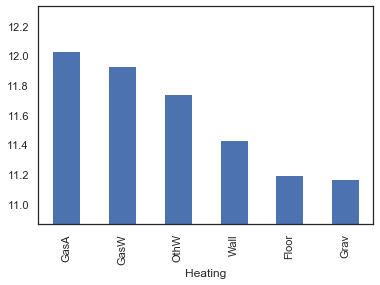

In [97]:
EDA_categorical(df, "Heating")

In [98]:
# Probably not that important, considering 1428 out of 1460 have the same classification

# Variable 40: HeatingQC (Heating quality and condition)

Number of missing values:  0

Unique values and their frequencies:
Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

Mean LogSalePrice in different groups of HeatingQC
HeatingQC
Ex    12.207626
Gd    11.910371
TA    11.816065
Fa    11.637034
Po    11.373663
Name: LogSalePrice, dtype: float64


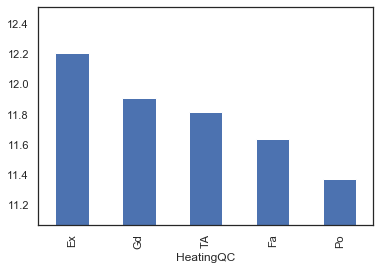

In [99]:
EDA_categorical(df, "HeatingQC")

In [100]:
# Strong predictor, we definitely need this predictor, I think

# Variable 41: CentralAir

Number of missing values:  0

Unique values and their frequencies:
Y    1365
N      95
Name: CentralAir, dtype: int64

Mean LogSalePrice in different groups of CentralAir
CentralAir
Y    12.061090
N    11.491858
Name: LogSalePrice, dtype: float64


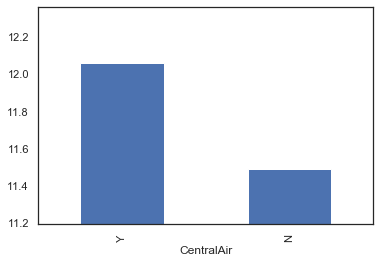

In [101]:
EDA_categorical(df, "CentralAir")

# Variable 42: Electrical

Number of missing values:  1

Unique values and their frequencies:
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

Mean LogSalePrice in different groups of Electrical
Electrical
SBrkr    12.061464
FuseA    11.660315
FuseF    11.539624
FuseP    11.446808
Mix      11.112448
Name: LogSalePrice, dtype: float64


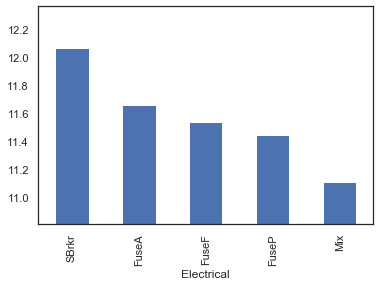

In [102]:
EDA_categorical(df, "Electrical")

# Variable 43: 1stFlrSF

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

Correlation with housing prices:0.61
Correlation with housing price after removing outliers: 0.63
Number of outliers that is removed:4
Plots after removing outliers


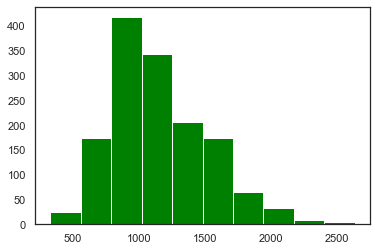

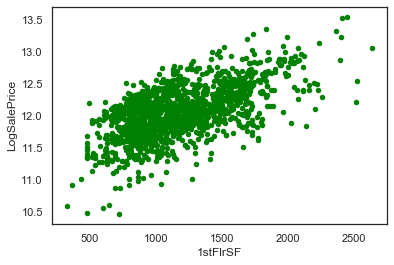

In [103]:
EDA_numeric(df, "1stFlrSF")

# Variable 44: 2ndFlrSF

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

Correlation with housing prices:0.32
Correlation with housing price after removing outliers: 0.32
Number of outliers that is removed:0
Plots after removing outliers


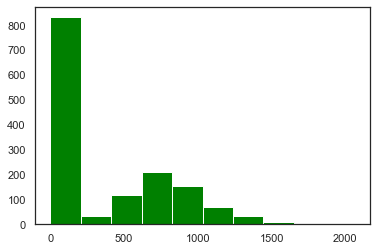

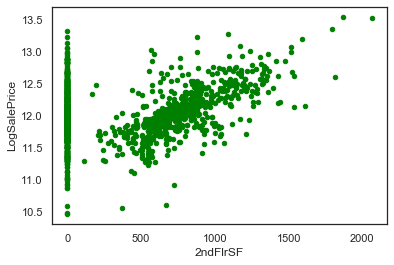

In [104]:
EDA_numeric(df, "2ndFlrSF")

# Variable 45: LowQualFinSF

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

Correlation with housing prices:-0.03
Correlation with housing price after removing outliers: -0.04
Number of outliers that is removed:19
Plots after removing outliers


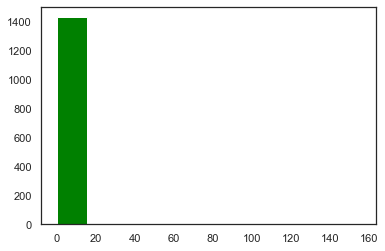

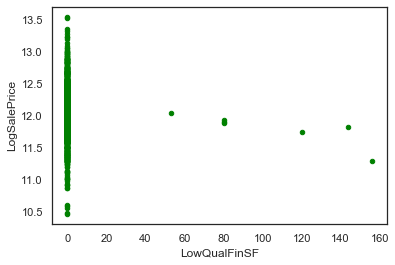

In [105]:
EDA_numeric(df, "LowQualFinSF")

# Variable 46: GrLivArea

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

Correlation with housing prices:0.71
Correlation with housing price after removing outliers: 0.72
Number of outliers that is removed:5
Plots after removing outliers


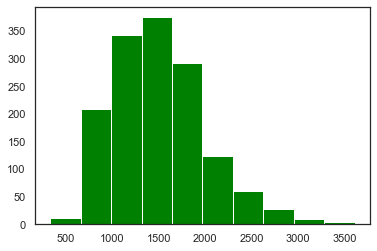

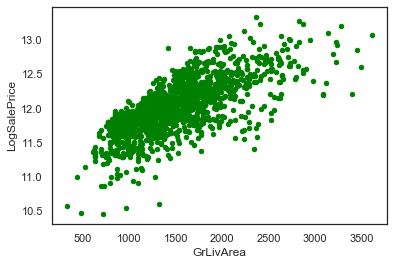

In [106]:
EDA_numeric(df, "GrLivArea")

# Variable 47: BsmtFullBath

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        0.425342
std         0.518911
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64

Correlation with housing prices:0.23
Correlation with housing price after removing outliers: 0.23
Number of outliers that is removed:1
Plots after removing outliers


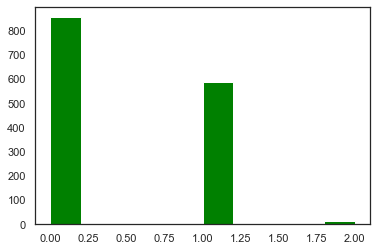

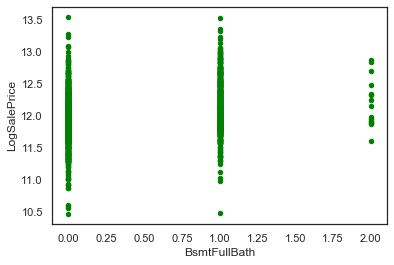

In [107]:
EDA_numeric(df, "BsmtFullBath")

# Variable 48: BsmtHalfBath

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        0.057534
std         0.238753
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64

Correlation with housing prices:-0.02
Correlation with housing price after removing outliers: -0.01
Number of outliers that is removed:2
Plots after removing outliers


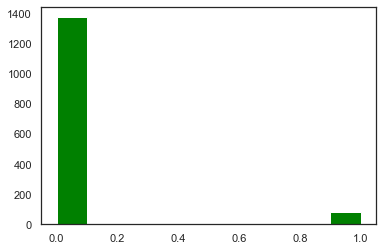

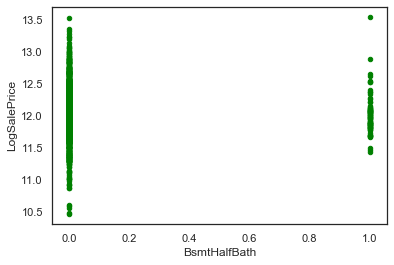

In [108]:
EDA_numeric(df, "BsmtHalfBath")

# Variable 49: FullBath

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        1.565068
std         0.550916
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64

Correlation with housing prices:0.56
Correlation with housing price after removing outliers: 0.56
Number of outliers that is removed:0
Plots after removing outliers


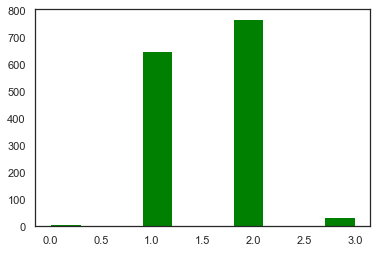

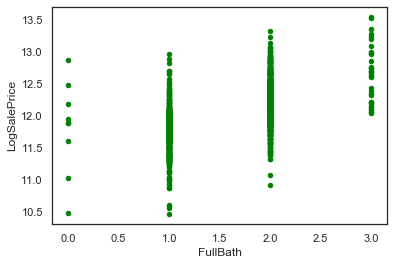

In [109]:
EDA_numeric(df, "FullBath")

# Variable 50: HalfBath

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        0.382877
std         0.502885
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: HalfBath, dtype: float64

Correlation with housing prices:0.28
Correlation with housing price after removing outliers: 0.28
Number of outliers that is removed:0
Plots after removing outliers


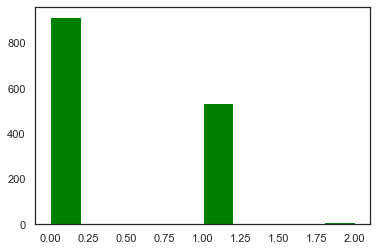

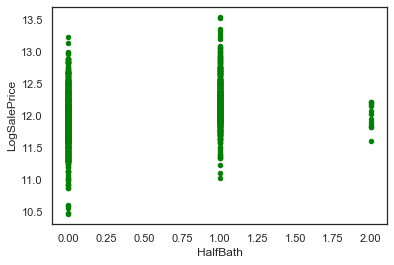

In [110]:
EDA_numeric(df, "HalfBath")

# Variable 51: BedroomAbvGr

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        2.866438
std         0.815778
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64

Correlation with housing prices:0.17
Correlation with housing price after removing outliers: 0.17
Number of outliers that is removed:1
Plots after removing outliers


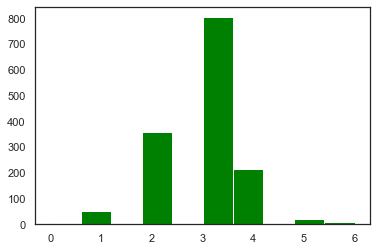

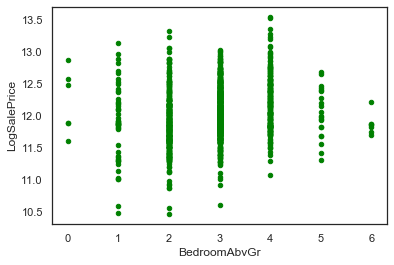

In [111]:
EDA_numeric(df, "BedroomAbvGr")

# Variable 52: KitchenAbvGr

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        1.046575
std         0.220338
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64

Correlation with housing prices:-0.14
Correlation with housing price after removing outliers: nan
Number of outliers that is removed:68
Plots after removing outliers


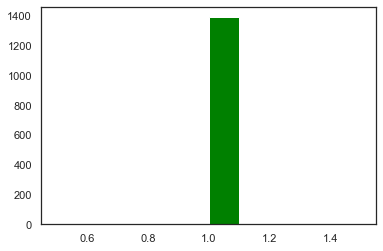

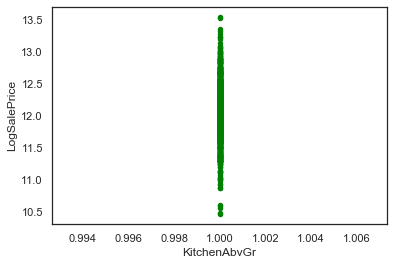

In [112]:
EDA_numeric(df, "KitchenAbvGr")

# Variable 53: KitchenQual

Number of missing values:  0

Unique values and their frequencies:
TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

Mean LogSalePrice in different groups of KitchenQual
KitchenQual
Ex    12.633614
Gd    12.222337
TA    11.810592
Fa    11.504581
Name: LogSalePrice, dtype: float64


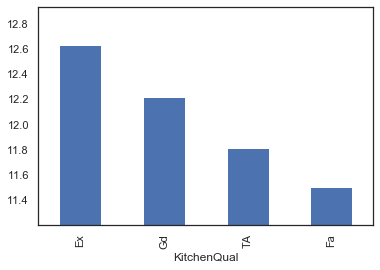

In [113]:
EDA_categorical(df, "KitchenQual")

# Variable 54: TotRmsAbvGrd

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        6.517808
std         1.625393
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64

Correlation with housing prices:0.53
Correlation with housing price after removing outliers: 0.54
Number of outliers that is removed:1
Plots after removing outliers


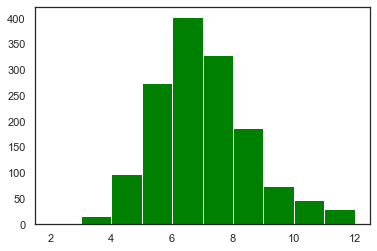

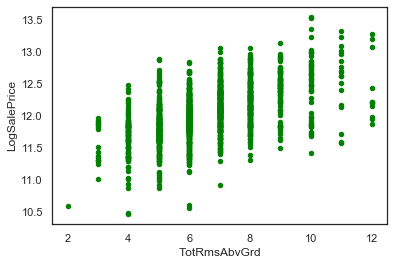

In [114]:
EDA_numeric(df, "TotRmsAbvGrd")

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        2.279708
std         0.372419
min         0.748277
25%         1.928035
50%         2.192232
75%         2.423951
max         3.567769
Name: TotRmsAbvGrd_Box_Cox, dtype: float64

Correlation with housing prices:0.52
Correlation with housing price after removing outliers: 0.52
Number of outliers that is removed:1
Plots after removing outliers


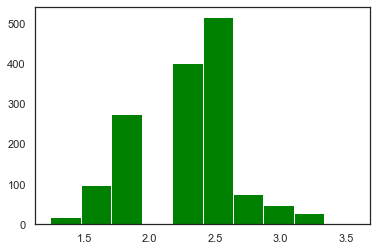

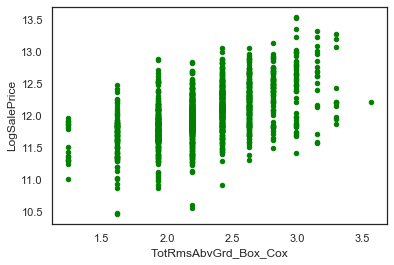

In [152]:
df["TotRmsAbvGrd_Box_Cox"] =box_cox_transform(df, "TotRmsAbvGrd")
EDA_numeric(df, "TotRmsAbvGrd_Box_Cox")

# Variable 55: Functional

Number of missing values:  0

Unique values and their frequencies:
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

Mean LogSalePrice in different groups of Functional
Functional
Typ     12.038511
Min1    11.862167
Maj1    11.859618
Mod     11.858672
Min2    11.845498
Sev     11.767568
Maj2    11.316555
Name: LogSalePrice, dtype: float64


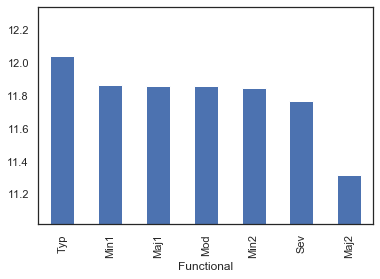

In [115]:
EDA_categorical(df, "Functional")

# Variable 56: Fireplaces

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        0.613014
std         0.644666
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Fireplaces, dtype: float64

Correlation with housing prices:0.47
Correlation with housing price after removing outliers: 0.47
Number of outliers that is removed:0
Plots after removing outliers


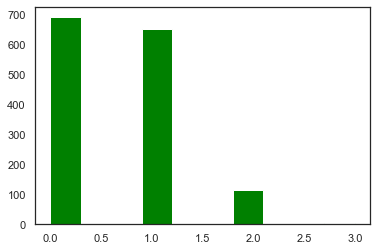

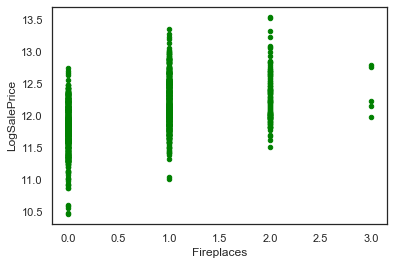

In [116]:
EDA_numeric(df, "Fireplaces")

# Variable 57: FireplaceQu

Number of missing values:  690

Unique values and their frequencies:
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

Mean LogSalePrice in different groups of FireplaceQu
FireplaceQu
Ex    12.670019
Gd    12.256533
TA    12.186416
Fa    12.008509
Po    11.738817
Name: LogSalePrice, dtype: float64


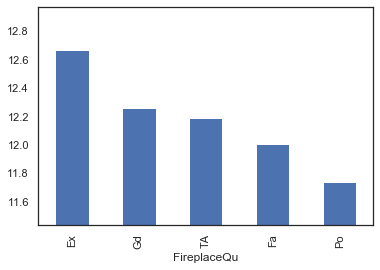

In [117]:
EDA_categorical(df, "FireplaceQu")

# Variable 58: GarageType

Number of missing values:  81

Unique values and their frequencies:
Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

Mean LogSalePrice in different groups of GarageType
GarageType
BuiltIn    12.374919
Attchd     12.160778
Basment    11.916440
2Types     11.899157
Detchd     11.765643
CarPort    11.587994
Name: LogSalePrice, dtype: float64


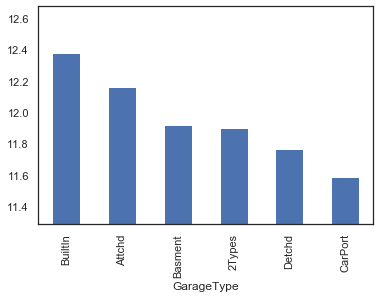

In [118]:
EDA_categorical(df, "GarageType")

# Variable 59: GarageYrBlt

Number of missing values:  81

Unique values and their frequencies:
2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1908.0     1
1927.0     1
1933.0     1
1900.0     1
1906.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

Mean LogSalePrice in different groups of GarageYrBlt
GarageYrBlt
2010.0    12.697243
2008.0    12.586248
2009.0    12.549086
2006.0    12.435365
1908.0    12.388394
            ...    
1924.0    11.660625
1927.0    11.652687
1920.0    11.503842
1952.0    11.463013
1938.0    11.363950
Name: LogSalePrice, Length: 97, dtype: float64


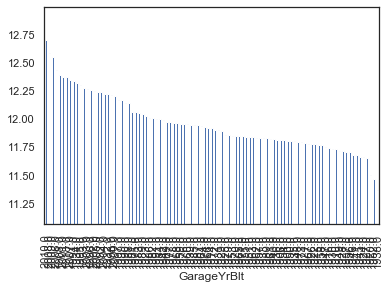

In [119]:
#####
EDA_categorical(df, "GarageYrBlt")

# Variable 60: GarageFinish

Number of missing values:  81

Unique values and their frequencies:
Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

Mean LogSalePrice in different groups of GarageFinish
GarageFinish
Fin    12.320811
RFn    12.172672
Unf    11.818974
Name: LogSalePrice, dtype: float64


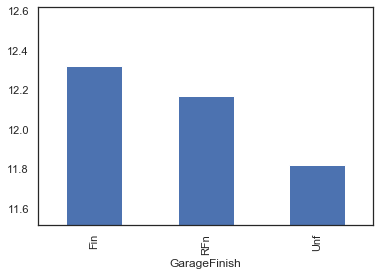

In [120]:
EDA_categorical(df, "GarageFinish")

In [150]:
df['GarageYrBlt'].corr(df['HouseAge'])

-0.8132551564243214

# Variable 61: GarageCars

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        1.767123
std         0.747315
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64

Correlation with housing prices:0.64
Correlation with housing price after removing outliers: 0.64
Number of outliers that is removed:0
Plots after removing outliers


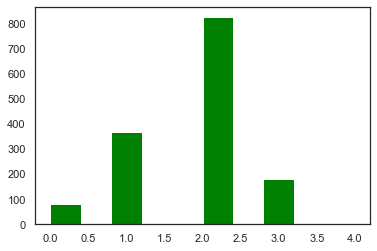

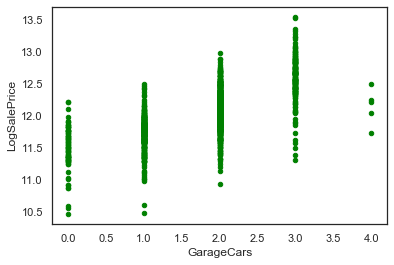

In [121]:
EDA_numeric(df, "GarageCars")

# Variable 62: GarageArea

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

Correlation with housing prices:0.62
Correlation with housing price after removing outliers: 0.63
Number of outliers that is removed:3
Plots after removing outliers


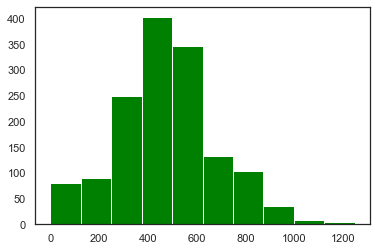

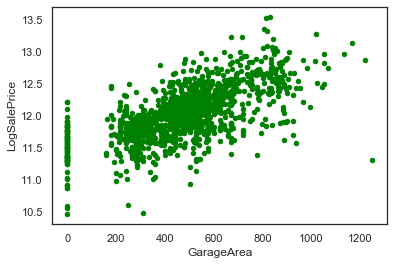

In [122]:
EDA_numeric(df, "GarageArea")

# Variable 63: GarageQual

Number of missing values:  81

Unique values and their frequencies:
TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

Mean LogSalePrice in different groups of GarageQual
GarageQual
Gd    12.220068
Ex    12.175449
TA    12.068539
Fa    11.674845
Po    11.472494
Name: LogSalePrice, dtype: float64


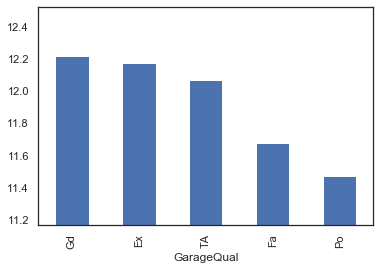

In [123]:
EDA_categorical(df, "GarageQual")

# Variable 64: GarageCond

Number of missing values:  81

Unique values and their frequencies:
TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

Mean LogSalePrice in different groups of GarageCond
GarageCond
TA    12.070483
Gd    12.050615
Ex    11.727638
Fa    11.596881
Po    11.572878
Name: LogSalePrice, dtype: float64


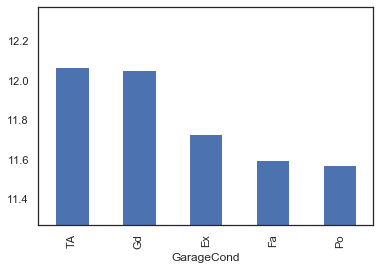

In [124]:
EDA_categorical(df, "GarageCond")

# Variable 65: PavedDrive

Number of missing values:  0

Unique values and their frequencies:
Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

Mean LogSalePrice in different groups of PavedDrive
PavedDrive
Y    12.059895
P    11.761352
N    11.577941
Name: LogSalePrice, dtype: float64


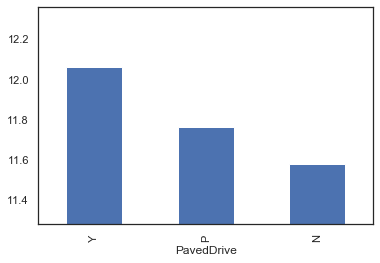

In [125]:
EDA_categorical(df, "PavedDrive")

# Variable 66: WoodDeckSF

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

Correlation with housing prices:0.32
Correlation with housing price after removing outliers: 0.33
Number of outliers that is removed:6
Plots after removing outliers


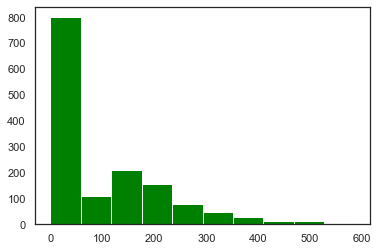

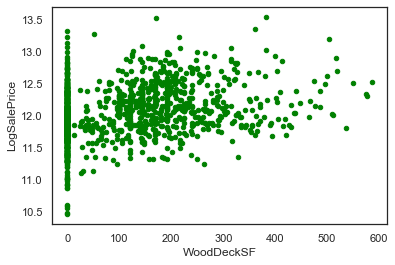

In [126]:
EDA_numeric(df, "WoodDeckSF")

# Variable 67: OpenPorchSF

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

Correlation with housing prices:0.32
Correlation with housing price after removing outliers: 0.35
Number of outliers that is removed:10
Plots after removing outliers


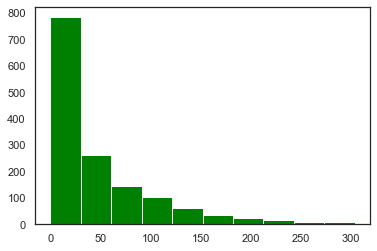

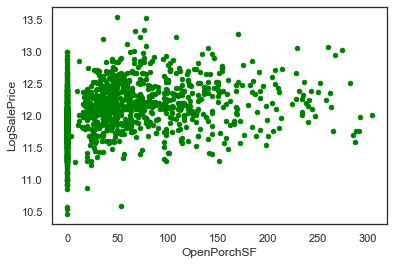

In [127]:
EDA_numeric(df, "OpenPorchSF")

# Variable 68: EnclosedPorch

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

Correlation with housing prices:-0.13
Correlation with housing price after removing outliers: -0.16
Number of outliers that is removed:13
Plots after removing outliers


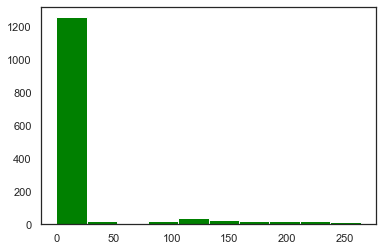

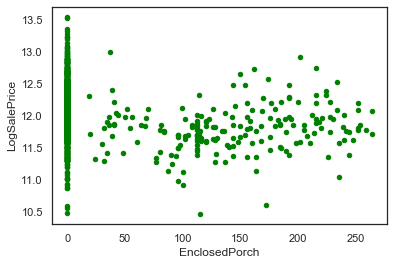

In [128]:
EDA_numeric(df, "EnclosedPorch")

# Variable 69: 3SsnPorch

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

Correlation with housing prices:0.04
Correlation with housing price after removing outliers: -0.00
Number of outliers that is removed:22
Plots after removing outliers


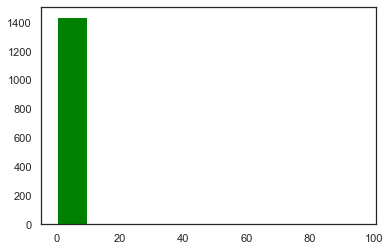

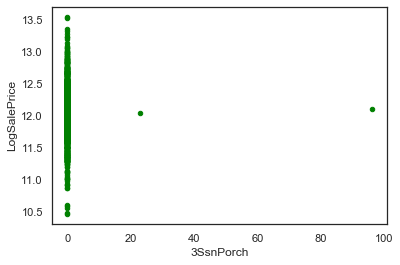

In [129]:
EDA_numeric(df, "3SsnPorch")

# Variable 70: ScreenPorch

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

Correlation with housing prices:0.11
Correlation with housing price after removing outliers: 0.09
Number of outliers that is removed:22
Plots after removing outliers


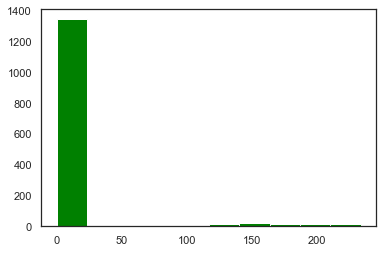

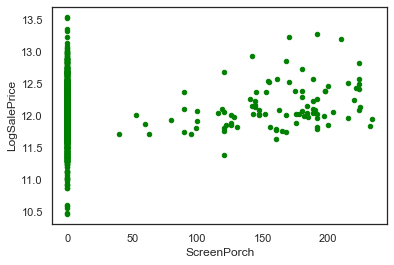

In [130]:
EDA_numeric(df, "ScreenPorch")

# Variable 71: PoolArea

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

Correlation with housing prices:0.09
Correlation with housing price after removing outliers: nan
Number of outliers that is removed:7
Plots after removing outliers


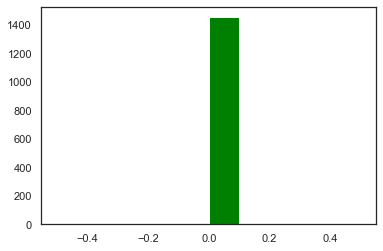

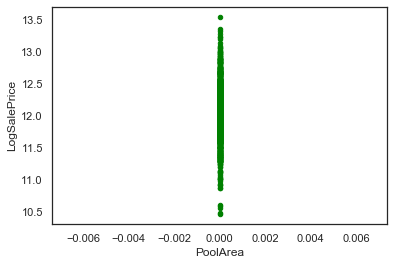

In [131]:
EDA_numeric(df, "PoolArea")

# Variable 72: PoolQC

Number of missing values:  1453

Unique values and their frequencies:
Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

Mean LogSalePrice in different groups of PoolQC
PoolQC
Ex    12.944240
Fa    12.267734
Gd    12.185588
Name: LogSalePrice, dtype: float64


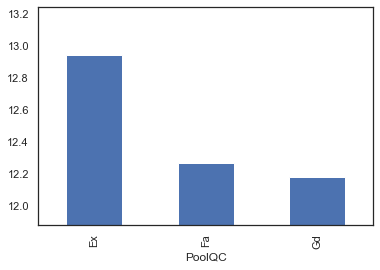

In [132]:
EDA_categorical(df, "PoolQC")

# Variable 73: Fence

Number of missing values:  1179

Unique values and their frequencies:
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

Mean LogSalePrice in different groups of Fence
Fence
GdPrv    12.057113
MnPrv    11.850596
MnWw     11.796800
GdWo     11.784233
Name: LogSalePrice, dtype: float64


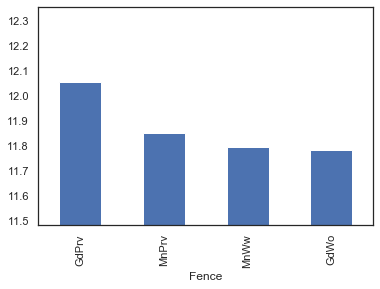

In [133]:
EDA_categorical(df, "Fence")

# Variable 74: MiscFeature

Number of missing values:  1406

Unique values and their frequencies:
Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

Mean LogSalePrice in different groups of MiscFeature
MiscFeature
TenC    12.429216
Gar2    12.041560
Shed    11.868387
Othr    11.356596
Name: LogSalePrice, dtype: float64


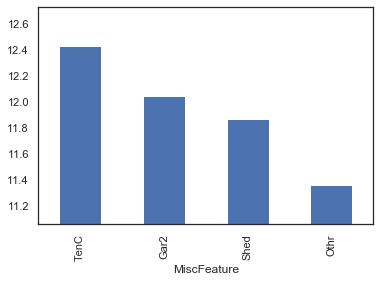

In [134]:
EDA_categorical(df, "MiscFeature")

# Variable 75: MiscVal

Number of missing values:  0

Quantile analysis:
count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

Correlation with housing prices:-0.02
Correlation with housing price after removing outliers: -0.03
Number of outliers that is removed:4
Plots after removing outliers


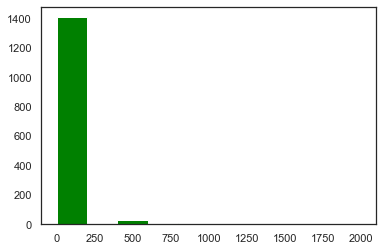

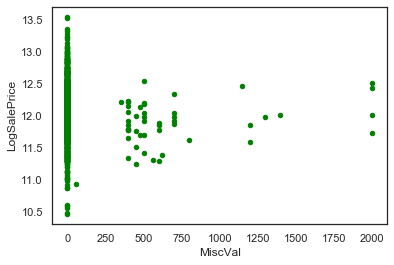

In [135]:
EDA_numeric(df, "MiscVal")

# Variable 76: MoSold

Number of missing values:  0

Unique values and their frequencies:
6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

Mean LogSalePrice in different groups of MoSold
MoSold
9     12.098561
11    12.074846
12    12.062260
8     12.049088
2     12.047052
7     12.042791
3     12.030134
10    12.020135
6     12.019938
5     11.984846
4     11.972056
1     11.963300
Name: LogSalePrice, dtype: float64


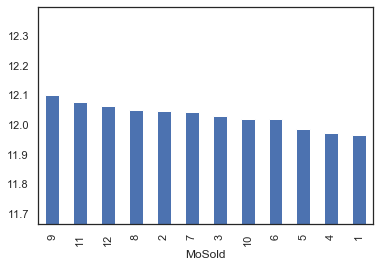

In [136]:
EDA_categorical(df, "MoSold")

# Variable 77: YrSold

Number of missing values:  0

Unique values and their frequencies:
2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

Mean LogSalePrice in different groups of YrSold
YrSold
2007    12.050668
2006    12.034985
2008    12.014205
2009    12.008737
2010    12.001072
Name: LogSalePrice, dtype: float64


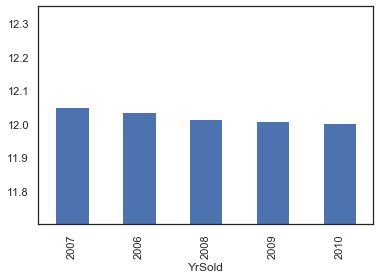

In [137]:
EDA_categorical(df, "YrSold")

# Variable 78: SaleType

Number of missing values:  0

Unique values and their frequencies:
WD       1267
New       122
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

Mean LogSalePrice in different groups of SaleType
SaleType
Con      12.483911
New      12.459372
CWD      12.198344
ConLI    12.044878
WD       11.991061
COD      11.827437
ConLD    11.773000
ConLw    11.769706
Oth      11.675295
Name: LogSalePrice, dtype: float64


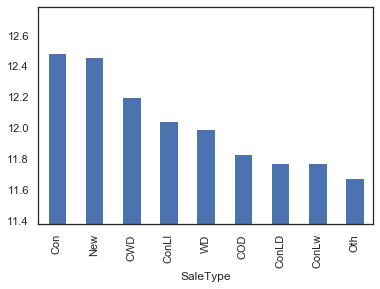

In [138]:
EDA_categorical(df, "SaleType")

# Variable 79: SaleCondition

Number of missing values:  0

Unique values and their frequencies:
Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

Mean LogSalePrice in different groups of SaleCondition
SaleCondition
Partial    12.447477
Normal     12.005034
Alloca     11.914458
Family     11.869655
Abnorml    11.788774
AdjLand    11.529147
Name: LogSalePrice, dtype: float64


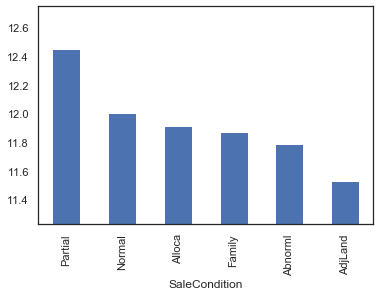

In [139]:
EDA_categorical(df, "SaleCondition")

# Variable 80: SalePrice

Number of missing values:  0

Quantile analysis:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Correlation with housing prices:1.00
Correlation with housing price after removing outliers: 1.00
Number of outliers that is removed:9
Plots after removing outliers


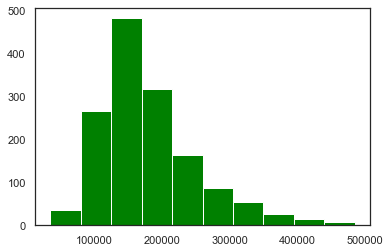

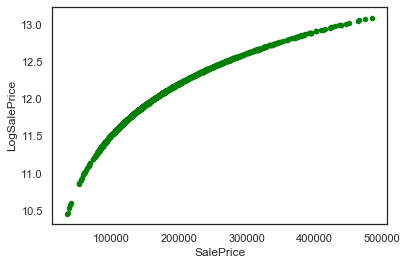

In [140]:
EDA_numeric(df, "SalePrice")

# Variable 81: HouseAge

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       22.950000
std        20.640653
min        -1.000000
25%         4.000000
50%        14.000000
75%        41.000000
max        60.000000
Name: HouseAge, dtype: float64

Correlation with housing prices:-0.51
Correlation with housing price after removing outliers: -0.51
Number of outliers that is removed:0
Plots after removing outliers


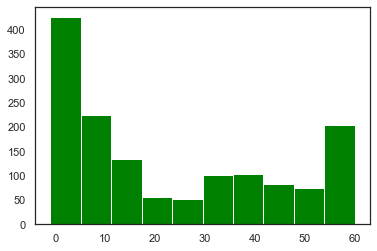

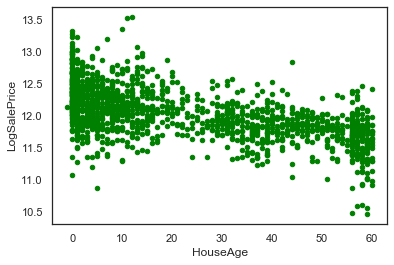

In [141]:
EDA_numeric(df, "HouseAge")

# Variable 82 AdjTotalBsmtSF

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean     1000.705411
std       422.269327
min         0.000000
25%       747.150000
50%       941.100000
75%      1231.200000
max      6063.400000
Name: AdjTotalBsmtSF, dtype: float64

Correlation with housing prices:0.62
Correlation with housing price after removing outliers: 0.65
Number of outliers that is removed:5
Plots after removing outliers


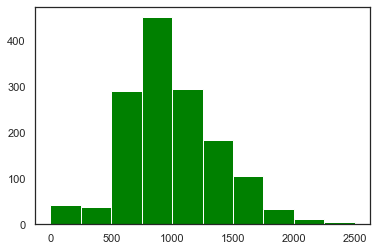

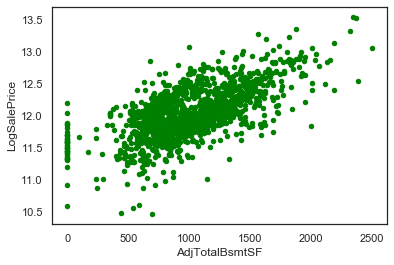

In [145]:
EDA_numeric(df, "AdjTotalBsmtSF")

# Variable 83 AdjTotalBath

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean        2.254658
std         0.807130
min         1.000000
25%         2.000000
50%         2.000000
75%         2.600000
max         6.000000
Name: AdjTotalBath, dtype: float64

Correlation with housing prices:0.63
Correlation with housing price after removing outliers: 0.64
Number of outliers that is removed:1
Plots after removing outliers


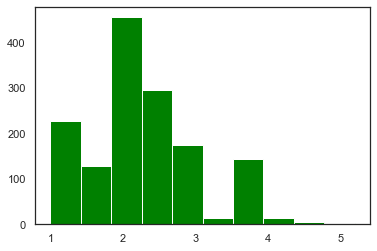

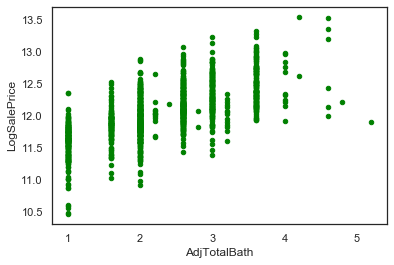

In [146]:
EDA_numeric(df, "AdjTotalBath")

# Variable 83 LogSalePrice

Number of missing values:  0

Quantile analysis:
count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: LogSalePrice, dtype: float64

Correlation with housing prices:0.95
Correlation with housing price after removing outliers: 0.95
Number of outliers that is removed:0
Plots after removing outliers


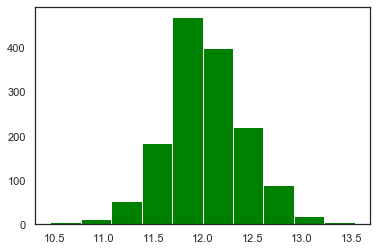

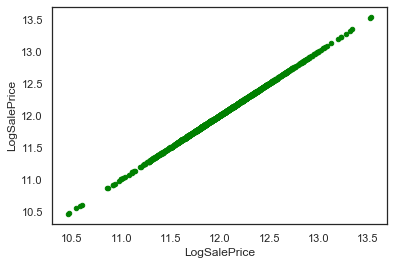

In [147]:
EDA_numeric(df, "LogSalePrice")